In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from config import input_datadir, result_datadir, IMAGES_datadir
import os
import fnmatch
import ARX_Optimization

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [3]:
# Specify Order

m = 2
n = 2

In [14]:
def plot_formatting(data, idx, outlier_run, maxtime_name):
    dfd_maxtime, sim_clean, maxrun, sim_maxtime, dfd_outlier, output_outlier, sim_outlier, sigmas, runtime, guess_err, error, max_error = data
    ax[0,0].set_title('Process Data and ID-simulation')
    ax[0,0].set_ylabel('Process Output')
    ax[0,0].set_ylim(10,70)
    ax[0,0].set_xlabel('(a)')

    
    ax[1,1].set_title('Coefficient Error.')
    ax[1,1].set_ylabel('Error')
#     ax[1,1].set_ylim(0,2)
    
    ax[1,0].set_title('Largest-error data and approximation.')
    ax[1,0].set_xlabel('(c) Time (s)')
    ax[1,0].set_ylabel('Process Output')
    ax[1,0].set_ylim(10,70)
    
    ax[0,1].set_title('Time elapsed coefficients.')
    ax[0,1].set_ylabel('Runtime')
    ax[0,1].set_xlabel('(b)')
    ax[0,1].set_ylim(0,100)
    
    ax[0,0].plot(dfd_maxtime[0].values, dfd_maxtime[1].values, color='b', label='Clean Data')
    ax[0,0].plot(dfd_maxtime[0].values, sim_clean, color='k', label='Clean approximation')
    ax[0,0].plot(dfd_maxtime[0].values, maxrun.values, color='grey', zorder=0, label = 'Slowest runtime Data')  # "('+'_'+os.path.splitext(maxtime_name)[0])"
    ax[0,0].plot(dfd_maxtime[0].values, sim_maxtime, '--', color='r', label='Slowest runtime approximation')

    ax[1,0].plot(dfd_outlier[0].values, output_outlier, color='k', alpha=0.5, label = 'Error Outlier Output') #+'_'+os.path.splitext(outlier_run)[0])
    ax[1,0].plot(dfd_outlier[0].values, sim_outlier, '--', color='k',label='Largest error approximation')
    ax[1,1].scatter(sigmas, error, color='k', marker='.', s=5)
    ax[1,1].scatter(sigmas[idx], max_error, color='k', marker='x', label= 'Largest Error') #os.path.splitext(outlier_run)[0])
    ax[1,1].scatter(sigmas, guess_err, color='g', marker='.', s=5, label='initial guess')
    ax[1,1].set_xlabel('(d) standard deviation')


    ax[0,1].scatter(sigmas, runtime, color='k', marker='.', s=5)
    ax[0,1].scatter(sigmas[runtime.index(max(runtime))], max(runtime), color='k', marker='x', label='Slowest Runtime')

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()
    plt.tight_layout()
    image_name = os.path.splitext(outlier_run)[0]+'.pdf'
    fig.savefig(IMAGES_datadir/image_name, bbox_inches='tight')


In [15]:
def do_sim(ydata, data, pt, ptr):
    dfr_maxtime, dfr_outlier, dfd_maxtime, dfd_outlier = ydata
    sim_clean = ARX_Optimization.simulate(dfr_maxtime.loc[0][:m+n].values, data.Q1.values, m, n) + dfd_maxtime[1][0] #change Q1 to work for any data set or code specific process inputs
    sim_maxtime = ARX_Optimization.simulate(dfr_maxtime.loc[ptr][:m+n].values, data.Q1.values, m, n) + dfd_maxtime[1][0] #change Q1 to work for any data set or code specific process inputs
    sim_outlier = ARX_Optimization.simulate(dfr_outlier.loc[pt][:m+n].values, data.Q1.values, m, n) + dfd_outlier[1][0] #change Q1 to work for any data set or code specific process inputs
    return sim_clean, sim_maxtime, sim_outlier
    

In [16]:
def max_er_rt(guess_err, error, runtime, sigmas, max_error, max_runtime, dfr, m, n):
    prev_max_error = max_error
    prev_max_runtime = max_runtime
    for i in range(0,len(dfr)):
        guess_diff=[]
        difference=[] 
        for j in range(m+n):
            guess_diff.append(abs(dfr[j][0] - 1))
            difference.append(abs(dfr[j][0] - dfr[j][i]))
        guess_err.append(sum(guess_diff))
        error.append(sum(difference))
        runtime.append(dfr[j+1][i])
        sigmas.append(dfr[j+2][i])
        max_error = max(error)
        max_runtime = max(runtime)
    return guess_err, error, runtime, sigmas, max_error, max_runtime, prev_max_error, prev_max_runtime

In [17]:
def extract_data(filename):
    dfd = dfd_outlier = pandas.read_excel(result_datadir/filename, sheet_name='Input_Data', header=None)
    dfr = pandas.read_excel(result_datadir/filename, sheet_name='ID_Results', header=None)
    return dfd, dfr

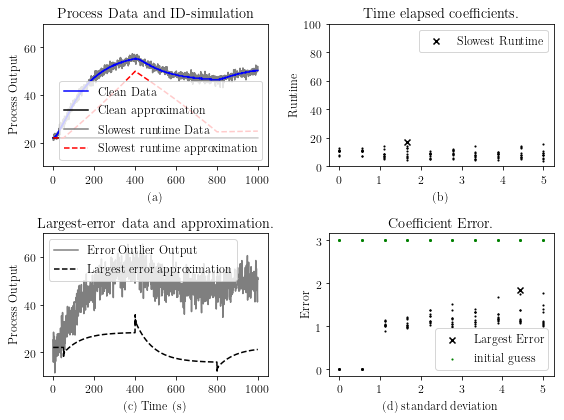

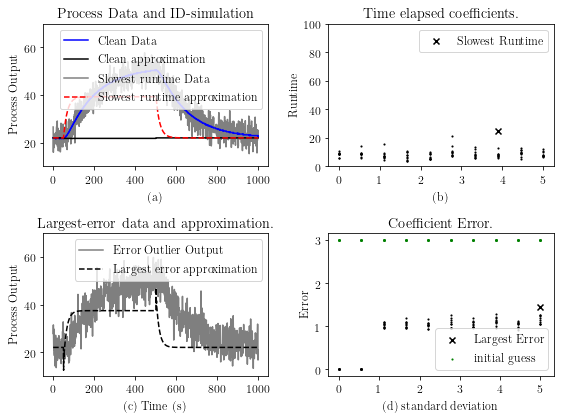

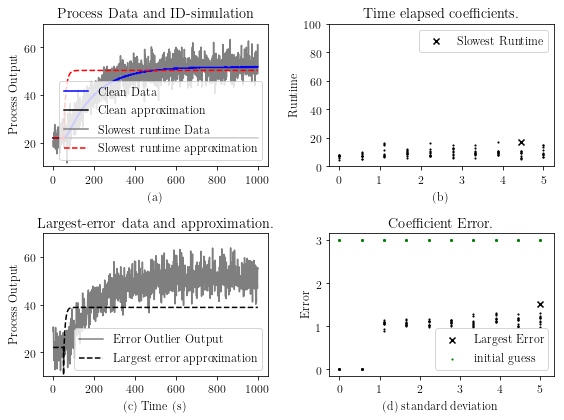

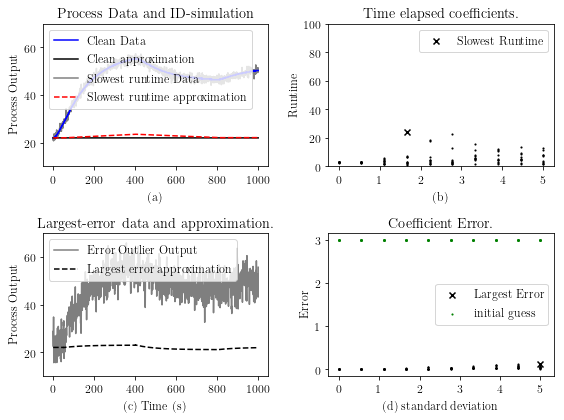

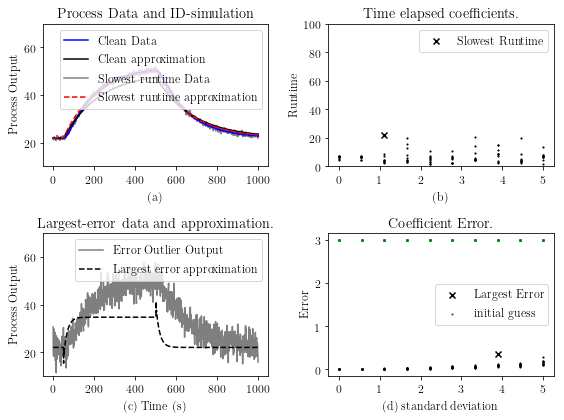

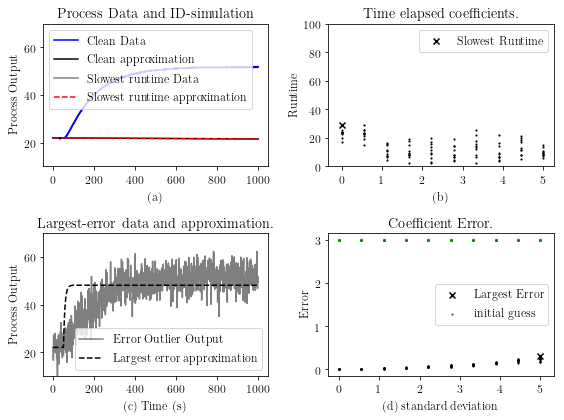

In [19]:
for method, method_name in zip(ARX_Optimization.ID_techs, ARX_Optimization.ID_tech_names[1:]): # change the [1:] back... DE didn't run for m=3, n=2 
# method_name=ARX_Optimization.ID_tech_names[1]
    for dataname in os.listdir(input_datadir):  # Get data filename
        if dataname.endswith('.csv'):
            fig, ax = plt.subplots(2,2, figsize=(8,6), frameon=False, )
            guess_err = []
            error = []
            runtime = []
            sigmas = []
            max_error = max_runtime = 0
            for resultname in os.listdir(result_datadir): # Get result filename
                if resultname.endswith('.xlsx') and fnmatch.fnmatch(os.path.splitext(resultname)[0], '*'+os.path.splitext(dataname)[0]+'*') and fnmatch.fnmatch(os.path.splitext(resultname)[0], '*'+method_name+'*') and fnmatch.fnmatch(os.path.splitext(resultname)[0], '*m'+str(m)+'_n'+str(n)+'*'): #group result filenames that match the data filename and ID technique
                    dfd, dfr = extract_data(resultname)
                    data = pandas.read_csv(input_datadir/dataname)

                    guess_err, error, runtime, sigmas, max_error, max_runtime, prev_max_error, prev_max_runtime = max_er_rt(guess_err, error, runtime, sigmas, max_error, max_runtime, dfr, m, n)

                    if max_error > prev_max_error:
                        idx = error.index(max_error)
                        outlier_run = resultname
                        dfd_outlier, dfr_outlier = extract_data(outlier_run)
                        if idx <= 9:
                            pt = idx
                        else:
                            pt = int(str(idx)[1])
                        output_outlier = dfd_outlier[pt]

                    if max_runtime > prev_max_runtime:
                        idxr = runtime.index(max_runtime)
                        maxtime_name = resultname
                        dfd_maxtime, dfr_maxtime = extract_data(maxtime_name)

                        if idxr <= 9:
                            ptr = idxr
                        else:
                            ptr = int(str(idxr)[1])
                            if ptr == 0:
                                ptr = 1
                        maxrun = dfd_maxtime[ptr]

            sim_clean, sim_maxtime, sim_outlier = do_sim([dfr_maxtime, dfr_outlier, dfd_maxtime, dfd_outlier], data, pt, ptr)
            data_lst = [dfd_maxtime, sim_clean, maxrun, sim_maxtime, dfd_outlier, output_outlier, sim_outlier, sigmas, runtime, guess_err, error, max_error]
            plot_formatting(data_lst, idx, outlier_run, maxtime_name)


